In [144]:
from graph_tool.all import *
import numpy as np
import matplotlib.pyplot as plt

## Graph Generation

In [135]:
def create_d_ary(N,d) :
    g = Graph()
    g.add_vertex(N)
    pred_map = g.vertex_index.copy()

    for i in range(N) :
        pred_map[i] = np.floor((i+d-2)/d)
        
    return graph_tool.generation.predecessor_tree(g,pred_map)

def create_price_network(N) :
    return price_network(N)

## Propagation

In [110]:
def chase_escape_pn_init_1(g, l, n_iter) :

	N = g.num_vertices()
	M = g.num_edges()

	#Couleurs des sommets
	colors = g.new_vertex_property("string")
	colors[0] = 'blue'
	colors[1] = 'red'
	for i in range(2,N) :
		colors[i] = 'white'

	#Stockage des arêtes S-I et I-R
	edges = g.get_edges()
	edges_si = np.zeros(M)
	edges_ir = np.zeros(M)

	edges_ir[0] = 1

	nb = g.get_in_edges(1, [g.edge_index])[:,2]
	for i in nb :
		edges_si[i] = 1

	#Nombre d'arêtes dans chaque tableau
	n_si = len(nb)
	n_ir = 1

	#Iterations
	for i in range(n_iter) :

		if n_ir == 0 and n_si == 0 :
			break

		#Probabilité que I se propage avant R
		p = l*n_si/(l*n_si + n_ir)

		if (np.random.rand() <= p) : #I se propage avant

			#Choix d'une arête S-I
			idx = np.random.choice(range(M), size=1, p=edges_si/n_si)
			e = edges[idx][0]
			v = e[0]

			#Contamination du sommet sain
			colors[v] = 'red'
			edges_si[idx] = 0
	
			#Actualisation du vecteur des arêtes S-I
			nb = g.get_in_edges(v, [g.edge_index])[:,2]
			for i in nb :
				edges_si[i] = 1
			n_si += len(nb) - 1
		
		else : #R se propage avant

			#Choix d'une arête I-R
			idx = np.random.choice(range(M), size=1, p=edges_ir/n_ir)
			e = edges[idx][0]
			v = e[0]
		
			#Vaccination du sommet infecté
			colors[v] = 'blue'
			edges_ir[idx] = 0
			n_ir -= 1
	
			#Actualisation des vecteurs des arêtes S-I et I-R
			nb = g.get_in_edges(v, [g.edge_index])[:,2]
			for i in nb :
				if edges_si[i] == 1 :
					edges_si[i] = 0
					n_si -= 1
				else :
					edges_ir[i] = 1
					n_ir += 1
                    
	return colors

def chase_escape_d_init_1(g, l, n_iter) :

	N = g.num_vertices()
	M = g.num_edges()	

	#Couleurs des sommets
	colors = g.new_vertex_property("string")
	colors[0] = 'blue'
	colors[1] = 'red'
	for i in range(2,N) :
		colors[i] = 'white'

	#Stockage des arêtes S-I et I-R
	edges = g.get_edges()
	edges_si = np.zeros(M)
	edges_ir = np.zeros(M)

	edges_ir[0] = 1

	nb = g.get_out_edges(1, [g.edge_index])[:,2]
	for i in nb :
		edges_si[i] = 1

	#Nombre d'arêtes dans chaque tableau
	n_si = len(nb)
	n_ir = 1

	#Iterations
	for i in range(n_iter) :

		if n_ir == 0 and n_si == 0 :
			break

		#Probabilité que I se propage avant R
		p = l*n_si/(l*n_si + n_ir)

		if (np.random.rand() <= p) : #I se propage avant

			#Choix d'une arête S-I
			idx = np.random.choice(range(M), size=1, p=edges_si/n_si)
			e = edges[idx][0]
			v = e[1]

			#Contamination du sommet sain
			colors[v] = 'red'
			edges_si[idx] = 0
	
			#Actualisation du vecteur des arêtes S-I
			nb = g.get_out_edges(v, [g.edge_index])[:,2]
			for i in nb :
				edges_si[i] = 1
			n_si += len(nb) - 1
		
		else : #R se propage avant

			#Choix d'une arête I-R
			idx = np.random.choice(range(M), size=1, p=edges_ir/n_ir)
			e = edges[idx][0]
			v = e[1]
		
			#Vaccination du sommet infecté
			colors[v] = 'blue'
			edges_ir[idx] = 0
			n_ir -= 1
	
			#Actualisation des vecteurs des arêtes S-I et I-R
			nb = g.get_out_edges(v, [g.edge_index])[:,2]
			for i in nb :
				if edges_si[i] == 1 :
					edges_si[i] = 0
					n_si -= 1
				else :
					edges_ir[i] = 1
					n_ir += 1
	return colors


## Drawing

In [32]:
def draw(g, c, size=8, width=0.1, name=None) :
	graph_draw(g, pos=sfdp_layout(g, cooling_step=0.99),vertex_fill_color=c, vertex_size=size, 
               edge_pen_width=width, output=name)

## Extinction probability

In [169]:
def estimate_extinction_prob_pn(N, l, n_iter):

	count = 0

	for _ in range(n_iter) :
		g = create_price_network(N)
		colors = chase_escape_pn_init_1(g, l, n_iter)
		if 'red' in colors :
			count += 1

	return count / n_iter

def estimate_extinction_prob_d(N, d, l, n_iter):

    count = 0
    g = create_d_ary(N, d)

    for _ in range(n_iter):
        colors = chase_escape_d_init_1(g, l, n_iter)
        if 'red' in colors :
            count += 1

    return count / n_iter


def plot_extinction_prob_pn(N, nb_iter):
	rates = np.arange(2, step = 0.01)
	extinction_probs = np.zeros(len(rates))

	for i in range(len(rates)):
		extinction_probs[i] = estimate_extinction_prob_pn(N, rates[i], nb_iter)

	plt.figure(figsize = (15, 10))
	plt.plot(rates, extinction_probs, 'o')
	plt.grid()
	plt.title("Probabilité d'extinction (N = {})".format(N))
	plt.xlabel("$\lambda$")
	plt.hlines(0.5, 0, 2, label = "$y = 0.5$")
	plt.legend()


def plot_extinction_prob_d(N, d, nb_iter):
    rates = np.arange(2, step = 0.01)
    extinction_probs = np.zeros(len(rates))

    for i in range(len(rates)):
        extinction_probs[i] = estimate_extinction_prob_d(N, d, rates[i], nb_iter)

    plt.figure(figsize = (15, 10))
    plt.plot(rates, extinction_probs, 'o')
    plt.grid()
    plt.title("Probabilité d'extinction (N = {}, d = {})".format(N, d))
    plt.xlabel("$\lambda$")
    
    l_th = 2*d - 1 - 2*np.sqrt(d*d - d)
    
    plt.axvline(l_th, label = "$x = th. crit. lambda$", c='black')
    plt.legend()


## Critical rate evaluation

In [182]:
def crit_rate_pn(N, n_iter, d_l, eps) :

	l_c = d_l
	
	while l_c <= 1.0 :
		count = 0
		for _ in range(n_iter):
			g = create_price_network(N)
			colors = chase_escape_pn_init_1(g, l_c, n_iter)
			if 'white' in colors :
				count += 1
		if count/n_iter < eps :
			l_c += d_l
		else : 
			return (l_c - d_l)

def crit_rate_d(N, d, n_iter, d_l, eps) :

	l_c = d_l
	
	while l_c <= 1.0 :
		count = 0
		for _ in range(n_iter):
			g = create_d_ary(N, d)
			colors = chase_escape_d_init_1(g, l_c, n_iter)
			if 'red' in colors :
				count += 1
		if count/n_iter < eps :
			l_c += d_l
		else : 
			return (l_c - d_l)


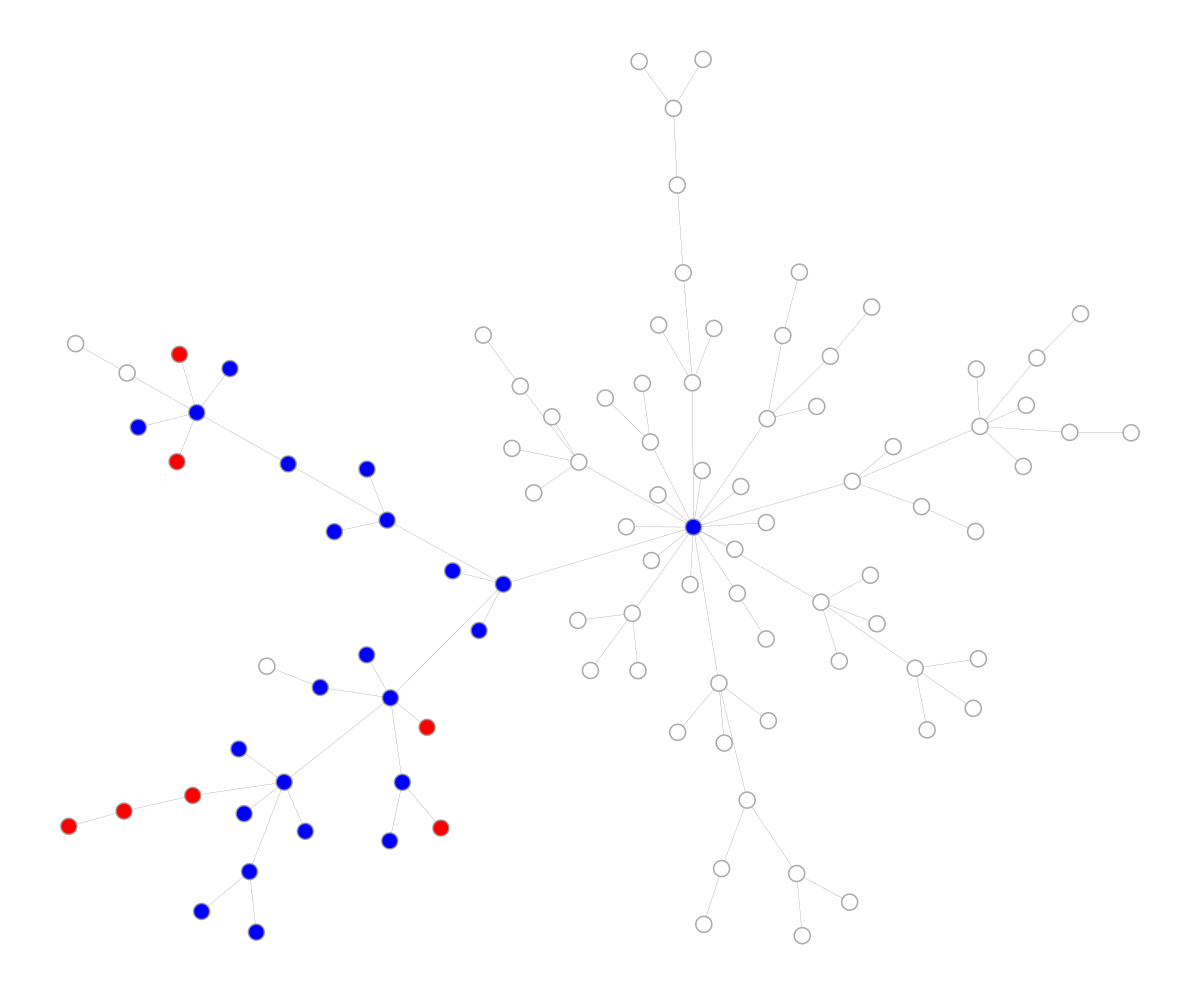

In [54]:
g = create_price_network(100)

c = chase_escape_pn_init_1(g, 1.0, 50)

draw(g, c)

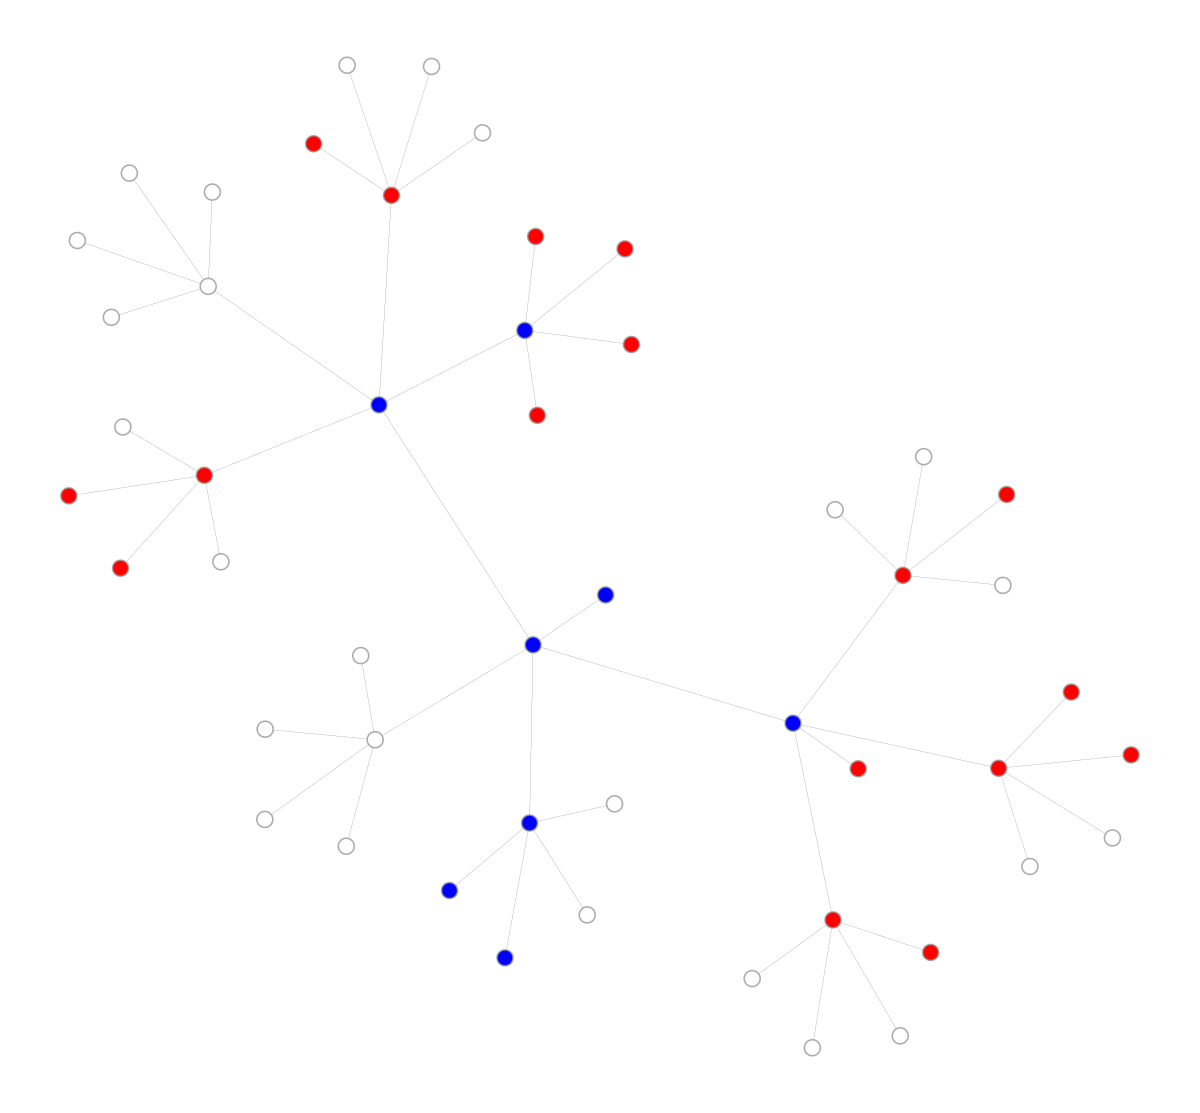

In [139]:
g = create_d_ary(50,4)

c = chase_escape_d_init_1(g, 1.0, 30)

draw(g, c)

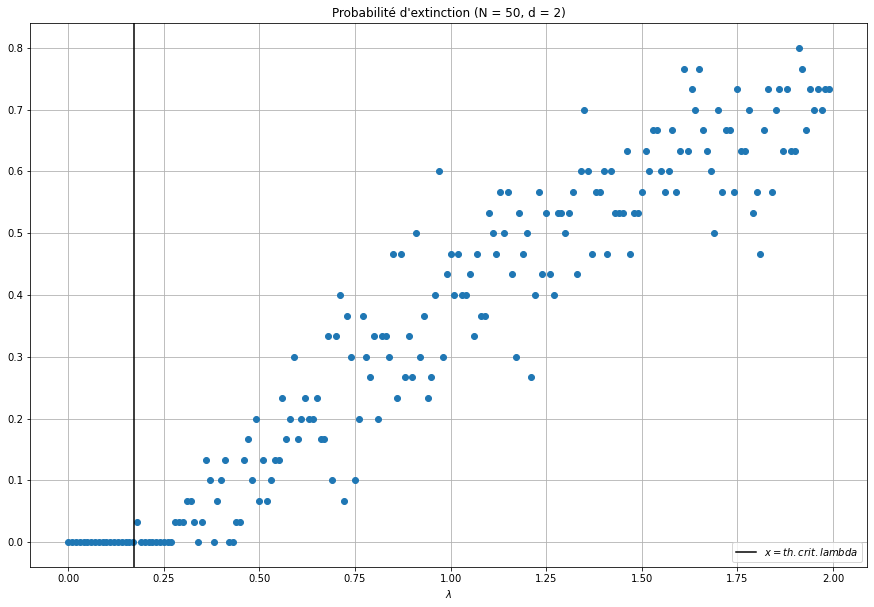

In [170]:
plot_extinction_prob_d(50, 2, 30)

In [201]:
crit_rate_d(50, 2, 30, 0.01, 0.0001)

0.18000000000000002